# QCS with SEQUENTIAL distribution in a star network - APPROX SOLUTIONS

We consider here a sequential QCS scheme in a star network. In a sequential scheme packets are sent sequentially.

Parameters:
 - `u`: number of users.
 - `k`: number of forwarding devices.
 - `p`: probability that the packets arrive at destination and can be decoded successfully.
 - `n_request`: number of pairs per request.
 - `w_request`: window size of the request.
 - `request_rate`: rate of arrival of new requests per pair of users.
 - `travel_time`: travel time from one user to another through the switch (assume homogeneous network).
 - `fwd_time`: time required to forward a packet.
 - `control_time`: time required to communicate with the network controller.

Our goal is to compute the Mean Sojourn Time (MST): $$\mathrm{MST} =  \mathbb{E}\left[T_\mathrm{service}\right] + \mathbb{E}\left[T_\mathrm{wait}\right]$$

The system can be modelled as an M/G/k queue, where the service time follows a general distribution given by the $(n,w,k,p)$-window problem. There is an analytical solution in the following cases:

 1. $p=1$, $k=1$:
     - Service time: the number of batches until success in the window problem is $\mathbb{E}\left[B_{n,w,1,1}\right]=n$, and $\mathrm{Var}\left[B_{n,w,1,1}\right]=0$.
     - Waiting time: the system becomes an M/D/k queue, whose exact solution is known. However, it is computationally expensive since it involves recursive integrals. For $k=1$ the solution can be easily computed.

 2. $w\rightarrow\infty$, $k=1$:
     - Service time: The number of batches until success in the window problem is $\mathbb{E}\left[B_{n,\infty,1,p}\right]=n/p$, and $\mathbb{E}\left[B_{n,w,1,p}^2\right]=n(n+1)/p^2 - n/p$, which can be used to compute $\mathbb{E}\left[T_\mathrm{service}\right]$ and $\mathrm{Var}\left[T_\mathrm{service}\right]$.
     - Waiting time: the system becomes an M/G/1 queue, whose expected waiting time is given by $$\mathbb{E}\left[T_\mathrm{wait}^\mathrm{M/G/1}\right] = \frac{C_\mathrm{service}^2+1}{2} \mathbb{E}\left[T_\mathrm{wait}^\mathrm{M/M/1}\right],$$ where $C_\mathrm{service}^2 = \mathrm{Var}\left[T_\mathrm{service}\right]/\mathbb{E}\left[T_\mathrm{service}\right]^2$ is the squared coefficient of variation of the service time distribution.
 
However, only approximations are known to the more general M/G/k queue. In the following cases, we can only find the MST via approximations (or simulations):

 3. $w\rightarrow\infty$, $k>1$:
     - Service time: given by the solution of the $(n,\infty,1,p)$-window problem. We have an analytical solution (which involves some nested sums).
     - Waiting time: the system becomes an M/G/k queue, where the waiting time can be approximated as $$\mathbb{E}\left[T_\mathrm{wait}^{\mathrm{M/G/}k}\right] \approx \frac{C_\mathrm{service}^2+1}{2} \mathbb{E}\left[T_\mathrm{wait}^{\mathrm{M/M/}k}\right].$$ This approximation seems to be better for service time distributions with smaller $C_\mathrm{service}^2$.

 4. Any $p$, $w$, $k$:
     - Service time: given by the solution of the $(n,w,1,p)$-window problem. Davies2023 provides an analytical method for $k=1$ but it is computationally expensive in general. We have to compute this with a simulation.
     - Waiting time: the system becomes an M/G/k queue, where the waiting time can be approximated as $$\mathbb{E}\left[T_\mathrm{wait}^{\mathrm{M/G/}k}\right] \approx \frac{C_\mathrm{service}^2+1}{2} \mathbb{E}\left[T_\mathrm{wait}^{\mathrm{M/M/}k}\right].$$ This approximation seems to be better for service time distributions with smaller $C_\mathrm{service}^2$. Since the window problem has to be solved with a simulation, we may as well use the QCS simulation to compute the MST directly.


In `VALIDATION-sQCS-exact.ipynb`,
 - ($i$) we use the analytical results to validate our QCS simulator in cases 1 and 2.
 
In this notebook,
 - ($ii$) we use our QCS simulations to validate the analytical approximations in 3, and
 - ($iii$) we compare the approximate solutions to our QCS simulation results in 4.

In [1]:
import numpy as np
import math
import importlib as imp
import QCSsimulator as sim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdmn

In [2]:
# Reference units
clock_cycle = 1 # [us]
speed_light = 0.2 # [km/us] Speed of light in optical fiber

# Protocol
distribution = 'sequential'

---
---
---
# 3. $w\rightarrow\infty$, $k>1$ (M/G/k) - validation of the analytical approximation

 - Service time: given by the solution of the $(n,\infty,k,p)$-window problem. We have an analytical solution (which involves some nested sums).
 - Waiting time: the system becomes an M/G/k queue, where the waiting time can be approximated as $$\mathbb{E}\left[T_\mathrm{wait}^{\mathrm{M/G/}k}\right] \approx \frac{C_\mathrm{service}^2+1}{2} \mathbb{E}\left[T_\mathrm{wait}^{\mathrm{M/M/}k}\right].$$ This approximation seems to be better for service time distributions with smaller $C_\mathrm{service}^2$.

### 3.1. $p=1$, $k=2$, $w\rightarrow\infty$

In [3]:
# Topology
u = 5 # Number of users in the star
internode_distance = 10 # [km]
travel_time = int(2*internode_distance/speed_light)
print('travel_time = %d'%travel_time)

# Requests
n_request = 7 # Number of entanglements requested per request
w_request = np.inf # [us] Time between delivery of first and last entangled pair
request_rate_vec = np.logspace(-5,-3,5) # [1/us] Request submission rate per pair of users

# Hardware
k = 2 # Number of forwarding devices
fwd_time = 1 # [us] Forwarding time
p = 1 # Probability of successful packet
control_time = 0 # [us]


# Numerical
N_samples = int(1e5)
randomseed = 2

travel_time = 100


In [4]:
imp.reload(sim)

MST_theory_vec = []
MST_sim_vec = []
MSTerr_sim_vec = []

for request_rate in tqdmn(request_rate_vec, leave=False):
    MST_sim, MSTerr_sim = sim.QCS_simulation(distribution, n_request, w_request, u, k, p,
                           request_rate, travel_time, fwd_time, control_time, N_samples, debugging=False)

    MST_theory = sim.QCS_theory(distribution, n_request, w_request, u, k, p,
                       request_rate, travel_time, fwd_time, control_time)[0]

    MST_theory_vec += [MST_theory]
    MST_sim_vec += [MST_sim]
    MSTerr_sim_vec += [MSTerr_sim]

  0%|          | 0/5 [00:00<?, ?it/s]

5 users
n = 7
k = 2
w = inf
p = 1.000


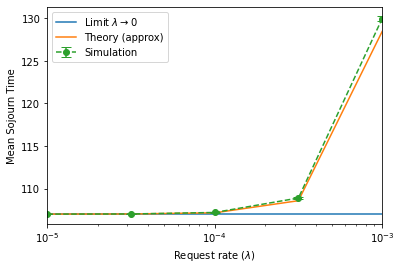

In [54]:
print('%d users'%u)
print('n = %d'%n_request)
print('k = %d'%k)
print('w = %s'%w_request)
print('p = %.3f'%p)

plt.plot([request_rate_vec[0],request_rate_vec[-1]],
         travel_time+n_request*fwd_time/p*np.ones(2),
         label=r'Limit $\lambda \rightarrow 0$')
plt.plot(request_rate_vec, MST_theory_vec, label='Theory (approx)')
plt.errorbar(request_rate_vec, MST_sim_vec, yerr=2*np.array(MSTerr_sim_vec),
             marker='o', linestyle='--', label='Simulation', capsize=5)
plt.xscale('log')
#plt.yscale('log')
plt.xlim(request_rate_vec[0],request_rate_vec[-1])
plt.legend()
plt.xlabel(r'Request rate ($\lambda$)')
plt.ylabel(r'Mean Sojourn Time')
plt.show()

### 3.2. $p=0.8$, $k=3$, $w\rightarrow\infty$

In [58]:
# Topology
u = 5 # Number of users in the star
internode_distance = 10 # [km]
travel_time = int(2*internode_distance/speed_light)
print('travel_time = %d'%travel_time)

# Requests
n_request = 7 # Number of entanglements requested per request
w_request = np.inf # [us] Time between delivery of first and last entangled pair
request_rate_vec = np.logspace(-5,-2,10) # [1/us] Request submission rate per pair of users

# Hardware
k = 3 # Number of forwarding devices
fwd_time = 1 # [us] Forwarding time
p = 0.8 # Probability of successful packet
control_time = 0 # [us]


# Numerical
N_samples = int(1e4)
randomseed = 2

travel_time = 100


In [59]:
imp.reload(sim)

MST_theory_vec = []
MST_sim_vec = []
MSTerr_sim_vec = []

for request_rate in tqdmn(request_rate_vec, leave=False):
    MST_sim, MSTerr_sim = sim.QCS_simulation(distribution, n_request, w_request, u, k, p,
                           request_rate, travel_time, fwd_time, control_time, N_samples, debugging=False)

    MST_theory = sim.QCS_theory(distribution, n_request, w_request, u, k, p,
                       request_rate, travel_time, fwd_time, control_time)[0]

    MST_theory_vec += [MST_theory]
    MST_sim_vec += [MST_sim]
    MSTerr_sim_vec += [MSTerr_sim]

  0%|          | 0/10 [00:00<?, ?it/s]

5 users
n = 7
k = 3
w = inf
p = 0.800


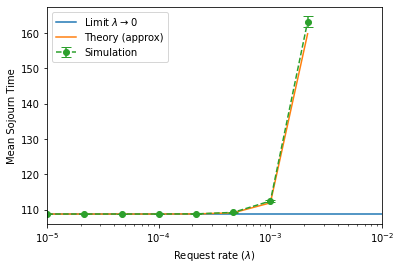

In [60]:
print('%d users'%u)
print('n = %d'%n_request)
print('k = %d'%k)
print('w = %s'%w_request)
print('p = %.3f'%p)

plt.plot([request_rate_vec[0],request_rate_vec[-1]],
         travel_time+n_request*fwd_time/p*np.ones(2),
         label=r'Limit $\lambda \rightarrow 0$')
plt.plot(request_rate_vec, MST_theory_vec, label='Theory (approx)')
plt.errorbar(request_rate_vec, MST_sim_vec, yerr=2*np.array(MSTerr_sim_vec),
             marker='o', linestyle='--', label='Simulation', capsize=5)
plt.xscale('log')
#plt.yscale('log')
plt.xlim(request_rate_vec[0],request_rate_vec[-1])
plt.legend()
plt.xlabel(r'Request rate ($\lambda$)')
plt.ylabel(r'Mean Sojourn Time')
plt.show()

---
---
---
# 4. Any $p$, $w$, $k$ (M/G/k) - full simulation

 - Service time: given by the solution of the $(n,w,k,p)$-window problem. Davies2023 provides an analytical method for $k=1$ but it is computationally expensive in general. We have to compute this with a simulation.
 - Waiting time: the system becomes an M/G/k queue, where the waiting time can be approximated as $$\mathbb{E}\left[T_\mathrm{wait}^{\mathrm{M/G/}k}\right] \approx \frac{C_\mathrm{service}^2+1}{2} \mathbb{E}\left[T_\mathrm{wait}^{\mathrm{M/M/}k}\right].$$ This approximation seems to be better for service time distributions with smaller $C_\mathrm{service}^2$.
     
Since the window problem (service time) has to be solved with a simulation, we will use the QCS simulation to compute the MST directly.